# Topic 4: Linear Regression


In [1]:
# please format the following table to read in python using numpy
import numpy as np
data = np.array([
0,22.8,
2.3,22.8,
4.9,22.8,
9.1,20.6,
13.7,13.9,
18.3,11.7,
22.9,11.1,
27.2,11.1]).T


In [2]:
z=data[0::2]
T=data[1::2]
z, T

(array([ 0. ,  2.3,  4.9,  9.1, 13.7, 18.3, 22.9, 27.2]),
 array([22.8, 22.8, 22.8, 20.6, 13.9, 11.7, 11.1, 11.1]))

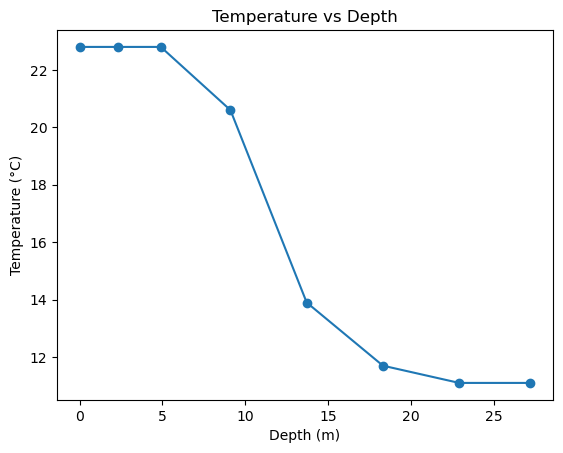

In [3]:

import matplotlib.pyplot as plt
plt.plot(z, T, 'o-')
plt.xlabel('Depth (m)')
plt.ylabel('Temperature (°C)')
plt.title('Temperature vs Depth')
plt.show()

In [4]:
# interpolate the data to find temperature at z = 15 m
from scipy.interpolate import interp1d      
interp_func = interp1d(z, T, kind='linear')
T_15 = interp_func(15)      

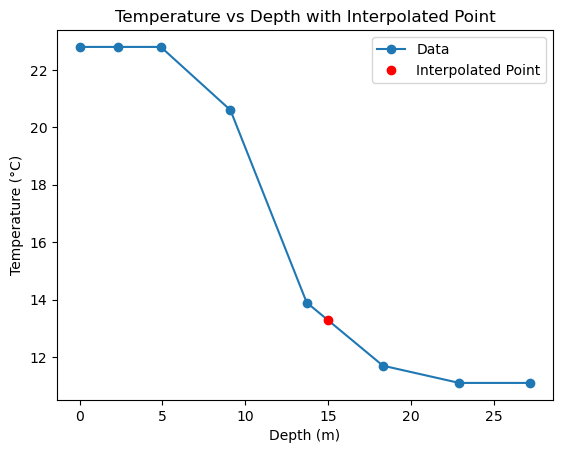

In [5]:
# plot the curve again with the interpolated point
plt.plot(z, T, 'o-', label='Data')
plt.plot(15, T_15, 'ro', label='Interpolated Point')
plt.xlabel('Depth (m)')
plt.ylabel('Temperature (°C)')
plt.title('Temperature vs Depth with Interpolated Point')
plt.legend()
plt.show()

In [6]:
# compute piecewise-linear gradient dT/dz and identify where its magnitude peaks
dz = np.diff(z)
dT = np.diff(T)
grad = dT / dz  # degC per m for each segment
mid_z = z[:-1] + dz / 2  # depth midpoints for each gradient value

max_drop_idx = np.argmin(grad)  # most negative slope = steepest cooling with depth
print(f"Segment mid-depth with steepest cooling: {mid_z[max_drop_idx]:.2f} m")
print(f"dT/dz there: {grad[max_drop_idx]:.2f} degC/m")
print("All segment gradients (degC/m):", grad)


Segment mid-depth with steepest cooling: 11.40 m
dT/dz there: -1.46 degC/m
All segment gradients (degC/m): [ 0.          0.         -0.52380952 -1.45652174 -0.47826087 -0.13043478
  0.        ]


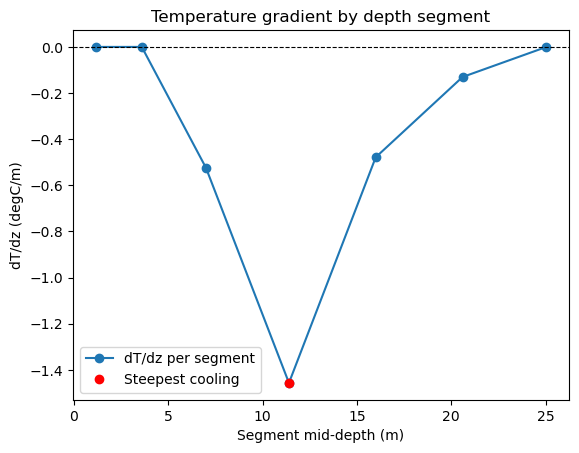

In [7]:
# visualize the gradients by segment midpoint
plt.plot(mid_z, grad, 'o-', label='dT/dz per segment')
plt.axhline(0, color='k', linestyle='--', linewidth=0.8)
plt.plot(mid_z[max_drop_idx], grad[max_drop_idx], 'ro', label='Steepest cooling')
plt.xlabel('Segment mid-depth (m)')
plt.ylabel('dT/dz (degC/m)')
plt.title('Temperature gradient by depth segment')
plt.legend()
plt.show()


In [8]:
# fit a 3rd-degree polynomial T(z) to the data
coeffs = np.polyfit(z, T, deg=3)
cubic = np.poly1d(coeffs)
z_fit = np.linspace(z.min(), z.max(), 200)
T_fit = cubic(z_fit)

print("Cubic coefficients (highest power first):")
for i, c in enumerate(coeffs):
    power = 3 - i
    print(f"  a{power} = {c:.6f}")
print("\nModel: T(z) = a3*z^3 + a2*z^2 + a1*z + a0")


Cubic coefficients (highest power first):
  a3 = 0.002673
  a2 = -0.100031
  a1 = 0.327707
  a0 = 22.876441

Model: T(z) = a3*z^3 + a2*z^2 + a1*z + a0


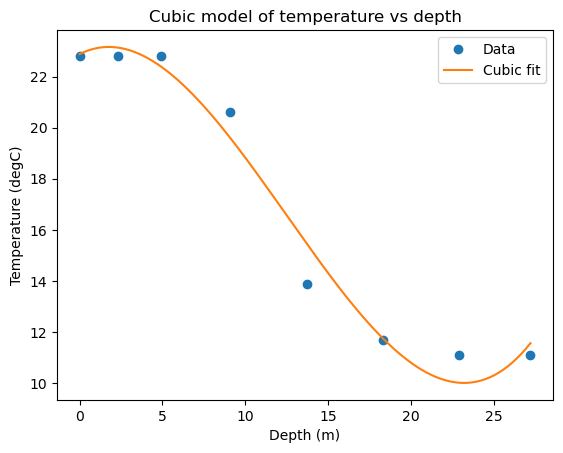

In [9]:
# plot the cubic model alongside the data
plt.plot(z, T, 'o', label='Data')
plt.plot(z_fit, T_fit, '-', label='Cubic fit')
plt.xlabel('Depth (m)')
plt.ylabel('Temperature (degC)')
plt.title('Cubic model of temperature vs depth')
plt.legend()
plt.show()


In [10]:
# build the normal-equation system shown in the figure for the cubic fit
n = len(z)
S = {
    0: n,
    1: np.sum(z),
    2: np.sum(z**2),
    3: np.sum(z**3),
    4: np.sum(z**4),
    5: np.sum(z**5),
    6: np.sum(z**6),
}
b = np.array([
    np.sum(T),
    np.sum(z * T),
    np.sum(z**2 * T),
    np.sum(z**3 * T),
])

A = np.array([
    [S[0], S[1], S[2], S[3]],
    [S[1], S[2], S[3], S[4]],
    [S[2], S[3], S[4], S[5]],
    [S[3], S[4], S[5], S[6]],
])

a = np.linalg.solve(A, b)
print("Normal-equation matrix A:\n", A)
print("Right-hand side b:\n", b)
print("Solution coefficients (a0..a3):", a)
print("polyfit coefficients (a3..a0) for comparison:", coeffs)


Normal-equation matrix A:
 [[8.00000000e+00 9.84000000e+01 1.89894000e+03 4.17158640e+04]
 [9.84000000e+01 1.89894000e+03 4.17158640e+04 9.77209882e+05]
 [1.89894000e+03 4.17158640e+04 9.77209882e+05 2.37861922e+07]
 [4.17158640e+04 9.77209882e+05 2.37861922e+07 5.93929093e+08]]
Right-hand side b:
 [1.36800000e+02 1.31227000e+03 2.29342050e+04 4.82600743e+05]
Solution coefficients (a0..a3): [ 2.28764414e+01  3.27707132e-01 -1.00031046e-01  2.67272524e-03]
polyfit coefficients (a3..a0) for comparison: [ 2.67272524e-03 -1.00031046e-01  3.27707132e-01  2.28764414e+01]


In [12]:
# estimate inflection depth(s) from the cubic: solve d2T/dz2 = 0
p = cubic  # np.poly1d from polyfit
p2 = p.deriv(m=2)
roots = p2.r
real_roots = roots[np.isreal(roots)].real
in_range = real_roots[(real_roots >= z.min()) & (real_roots <= z.max())]

print("Second derivative roots (all real parts):", real_roots)
print("In-depth-range inflection candidates:", in_range)
for r in in_range:
    print(f"  z = {r:.3f} m, T = {p(r):.3f} degC, dT/dz = {p.deriv()(r):.3f} degC/m")

if len(in_range) == 0:
    print("No real inflection within the data depth range")


Second derivative roots (all real parts): [12.47553682]
In-depth-range inflection candidates: [12.47553682]
  z = 12.476 m, T = 16.586 degC, dT/dz = -0.920 degC/m


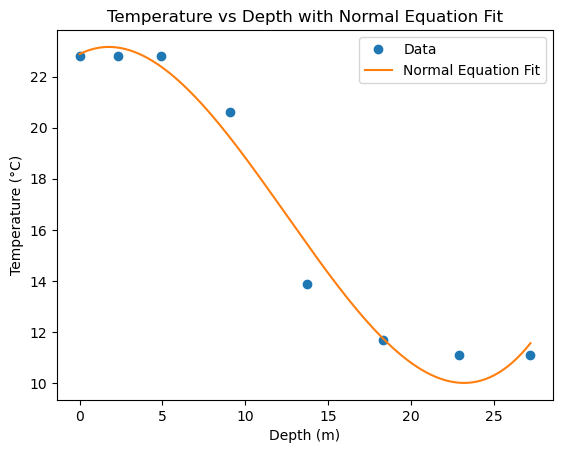

Text(0.5, 0, 'Depth (m)')

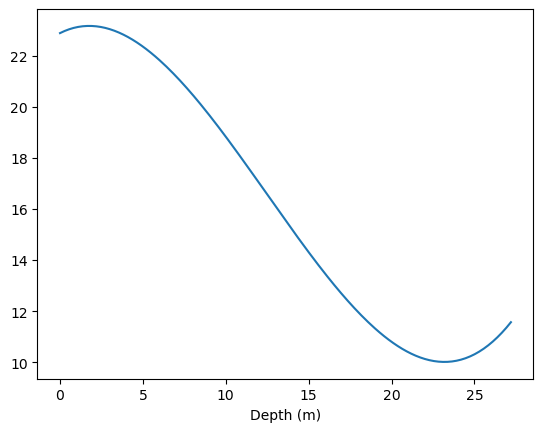

In [13]:
# make the plot with the normal-equation solution and the original points
T_ne = a[3]*z_fit**3 + a[2]*z_fit**2 + a[1]*z_fit + a[0]
plt.plot(z, T, 'o', label='Data')
plt.plot(z_fit, T_ne, '-', label='Normal Equation Fit')
plt.xlabel('Depth (m)')
plt.ylabel('Temperature (°C)')
plt.title('Temperature vs Depth with Normal Equation Fit')
plt.legend()
plt.show()
plt.plot(z_fit, T_ne, '-', label='Normal Equation Fit')
plt.xlabel('Depth (m)')